# **ML Final Project**:

### **Group Members:**
- Christopher Johnson (christopher.johnson13@ontariotechu.net)
- Alexander Sawatzky (alexander.sawatzky@ontariotechu.net)
- Cameron Millar (cameron.millar@ontariotechu.net)
- Jack Udeschini (jack.udeschini@ontariotechu.net)

## **Project Goals & Outline:**
The goal of this project is to use sentiment analysis to analyze the content of tweets, and make decisions on whether their sentiment is positive, negative, or neutral.

### Outline:
1. Data Importing and Preprocessing
2. Model Construction
   1. Recurrent Neural Network (RNN)
   2. Long Short-Term Memory (LSTM)
   3. Gated Recurrent Unit (GRU)
3. Model Training
   1. Training RNN Network
   2. Training LSTM Network
   3. Training GRU Network
4. Model Analysis and Comparison
   1. Analysis of RNN Model
   2. Analysis of LSTM Model
   3. Analysis of GRU Model
   4. Model Comparison
5. Conclusions

## **Importing Packages & Libraries:**

**Note:** Some libraries are imported automatically, while others have to be acquired manually.

In [67]:
# general packages/libraries
import numpy as np
import pandas as pd
from datetime import datetime # used to convert Date_time strings to useable format

# torch
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import random_split

# torchmetrics
%pip install torchmetrics
from torchmetrics import Accuracy

# torchtext
import torchtext.data
from torchtext.vocab import build_vocab_from_iterator

# lightning
%pip install lightning
from lightning.pytorch import LightningModule
from lightning.pytorch import Trainer
from lightning.pytorch.loggers import CSVLogger

# tqdm
from tqdm.notebook import tqdm

# nltk
import nltk # used for tokenziation
nltk.download('punkt')
from nltk import word_tokenize

# regular expressions
import re

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\chris\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## **Data Importing and Preprocessing:**
This section is where the tweet data is imported and processed into tokens. This tokenization process is required so the neural network architectures can interpret the text data.

**Tokenization definition:** the process of breaking down a sequence of information into smaller chunks known as tokens.

### Importing the Dataset:

In [68]:
# import the tweet data from the CSV using pandas
tweet_data = pd.read_csv('./Datasets/twitter_training.csv', names=['Tweet ID', 'entity', 'sentiment', 'Tweet content'])
tweet_data.head(10)

,Tweet ID,entity,sentiment,Tweet content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
5,2401,Borderlands,Positive,im getting into borderlands and i can murder y...
6,2402,Borderlands,Positive,So I spent a few hours making something for fu...
7,2402,Borderlands,Positive,So I spent a couple of hours doing something f...
8,2402,Borderlands,Positive,So I spent a few hours doing something for fun...
9,2402,Borderlands,Positive,So I spent a few hours making something for fu...


In [69]:
# droppping "irrelevant" sentiment values
tweet_data.drop(
    tweet_data[tweet_data['sentiment'] == 'Irrelevant'].index,
    inplace=True
)

# showing remaining sentiment distribution
tweet_data['sentiment'].value_counts()

sentiment
Negative    22542
Positive    20832
Neutral     18318
Name: count, dtype: int64

In [70]:
# extracting the the sentiment data for ease of use
sentiment = tweet_data['sentiment']

# the numerical representations of the sentiment values
sentiment_numerical = {
    'Positive': 0,
    'Negative': 1,
    'Neutral': 2,
}

# converting the sentiment data into a numerical form
sentiment.replace(to_replace=sentiment_numerical, inplace=True)

# showing the converted sentiment data
print(sentiment.head(10))

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
Name: sentiment, dtype: int64


In [71]:
# extracting the the tweet content for ease of use
content = tweet_data['Tweet content']

# showing the extracted content
print(content.head(10))

# convert content to an iterator
# content = iter(content)

0    im getting on borderlands and i will murder yo...
1    I am coming to the borders and I will kill you...
2    im getting on borderlands and i will kill you ...
3    im coming on borderlands and i will murder you...
4    im getting on borderlands 2 and i will murder ...
5    im getting into borderlands and i can murder y...
6    So I spent a few hours making something for fu...
7    So I spent a couple of hours doing something f...
8    So I spent a few hours doing something for fun...
9    So I spent a few hours making something for fu...
Name: Tweet content, dtype: object


In [72]:
'''
method that processes content and removes the following content:
- 1 word tweets
- tweets that contain only special characters (e.g. /, ., <, etc.)
'''
def process_content(values:pd.Series, sentiments:pd.Series):
    # convert series to list
    values = values.to_list()
    sentiments = sentiments.to_list()

    # records the number of tweets removed
    # (used to adjust the access index)
    num_removed = 0

    # #! DEBUG
    # url_matches = 0

    for i in tqdm(range(0, len(values))):
        # checks for 1 word tweet using a tokenizer
        if (len(word_tokenize(str(values[i - num_removed]))) <= 1):
            # print('(1) ', i, ': ', str(values[i - num_removed]))  #! DEBUG
            del values[i - num_removed]     # remove the tweet from the list
            del sentiments[i - num_removed]      # remove the corresponding sentiment as well
            num_removed += 1     # count the number of removed tweets

        # checks for tweets with only "...", " ", "[" or, "]"
        # (only removes the tweet if the match is >=75% of the tweet content)
        if (len(re.match(r'^(\.|\[|\]| |\n|[0-9])*', str(values[i - num_removed])).group(0)) >= int(len(str(values[i - num_removed]))*0.75)):
            # print('(2) ', i, ': ', str(values[i - num_removed]))  #! DEBUG
            del values[i - num_removed]     # remove the tweet from the list
            del sentiments[i - num_removed]      # remove the corresponding sentiment as well
            num_removed += 1     # count the number of removed tweets

        url_match = re.match(r'(https?:\ */\ */\ *)?(?:www\.)?[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}(?:\ */\ *[^\s]*)?', str(values[i - num_removed]))

        # removes the tweets with links if a match exists
        # if (url_match):
        #     print('(3) ', i, ': ', url_match.group(0))  #! DEBUG
        #     # del values[i - num_removed]     # remove the tweet from the list
        #     # del sentiments[i - num_removed]      # remove the corresponding sentiment as well
        #     # num_removed += 1     # count the number of removed tweets

        #     #! DEBUG
        #     url_matches += 1

    # #! DEBUG
    # print(url_matches)
    return (pd.Series(values), pd.Series(sentiments))

In [73]:
content, sentiment = process_content(content, sentiment)
content.head(10)

  0%|          | 0/61692 [00:00<?, ?it/s]

0    im getting on borderlands and i will murder yo...
1    I am coming to the borders and I will kill you...
2    im getting on borderlands and i will kill you ...
3    im coming on borderlands and i will murder you...
4    im getting on borderlands 2 and i will murder ...
5    im getting into borderlands and i can murder y...
6    So I spent a few hours making something for fu...
7    So I spent a couple of hours doing something f...
8    So I spent a few hours doing something for fun...
9    So I spent a few hours making something for fu...
dtype: object

In [74]:
# converting the sentiment data into a torch tensor
sentiment = torch.tensor(sentiment, dtype=torch.int64)

### Tokenization:

In [75]:
def iterate_tokens(df):
    for val in tqdm(df):
        yield word_tokenize(str(val))

vocab = build_vocab_from_iterator(
    iterate_tokens(content),
    min_freq = 5,
    specials = ['<unk>']
)

vocab.set_default_index(0)

len(vocab)

  0%|          | 0/59441 [00:00<?, ?it/s]

17481

In [76]:
# save the vocab to be used in the demonstration
torch.save(vocab, 'vocab.pth')

## **Creating Data Loaders:**
These data loaders are used by the models to access the tweet data. We will create two data loaders:
* Training dataloader: used to train the models.
* Validation dataloader: used to evaluate the performance of the models.

In [77]:
'''
method that generates the training and validation dataloaders using the holdout method
Takes three arguments:
- data to create training and validation dataloaders with
- the sentiment data
- the vocabulary values
- maximum tweet length (default is 250)
- size of batches (default is 32)
'''
def create_dataloaders(data:pd.Series, sentiments:pd.Series, vocab, max_length = 250, batch_size = 32):
    # create the sequences using the vocab
    sequences = [
        torch.tensor(
            vocab.lookup_indices(word_tokenize(str(tweet))),
            dtype = torch.int64
        ) for tweet in tqdm(content)
    ]

    # create the padded sequences
    padded_sequences = pad_sequence(sequences, batch_first=True)[:, :max_length]

    # create the training and validation datasets used to create the dataloaders
    (train_dataset, val_dataset) = random_split(TensorDataset(padded_sequences, sentiments), (0.7, 0.3))  # 70% train, 30% validation

    # create the training and validation dataloaders
    train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
    val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=batch_size)

    # return the training and validation dataloaders in a tuple
    return (train_dataloader, val_dataloader)


In [78]:
train_dataloader, val_dataloader = create_dataloaders(content, sentiment, vocab)

  0%|          | 0/59441 [00:00<?, ?it/s]

## **Model Creation:**
This is where the models being used are defined.

### **RNN Model:**

In [79]:
# a basic RNN classifier using a LightningModule
class RNN_classifier(LightningModule):
    def __init__(self, vocab_size, embedding_dimension, state_dimension):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dimension)
        self.rnn = nn.RNN(
            input_size = embedding_dimension,
            hidden_size = state_dimension,
            num_layers = 1, # hyperparameter
            batch_first = True
        )

        # possible outputs: positive, negative, neutral
        self.output = nn.Linear(state_dimension, 3)

        # activation function to provide probabilities
        self.activation = nn.Sigmoid()

        # monitors accuracy
        self.accuracy = Accuracy(task = 'multiclass', num_classes = 3)

    def forward(self, sequence_batch):
        embedded = self.embedding(sequence_batch)
        h_t, h_n = self.rnn(embedded)  # output features (h_t) and state (h_n)
        output = self.output(h_n[-1])
        output = self.activation(output)

        return output

    def loss(self, output, targets):
        loss = nn.CrossEntropyLoss()

        return loss(output, targets)

    def training_step(self, batch):
        inputs, targets = batch
        outputs = self.forward(inputs)
        loss = self.loss(outputs, targets)

        # get accuracy value
        self.accuracy(outputs, targets)

        # log the training accuracy
        self.log('training accuracy', self.accuracy, prog_bar = True)

        return loss

    def validation_step(self, batch):
        inputs, targets = batch
        outputs = self.forward(inputs)

        # get accuracy value
        self.accuracy(outputs, targets)

        # log the validation accuracy
        self.log('validation accuracy', self.accuracy, prog_bar = True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

### **GRU Model:**
GRU stands for **G**ated **R**ecurrent **U**nit, and it is a type of Recurrent Neural Network that uses gating mechanisms to control the information flow in and out of the network. It is a simpler alternative to LSTM, which we will be covering next. (https://www.geeksforgeeks.org/gated-recurrent-unit-networks/)

In [80]:
class GRU_classifier(LightningModule):
    def __init__(self, vocab_size, embedding_dimension):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dimension)
        self.GRU = nn.GRU(input_size = embedding_dimension, hidden_size = 100, batch_first=True)
        self.linear1 = nn.Linear(100, 62)
        self.ReLU = nn.ReLU()
        self.linear2 = nn.Linear(62, 32)

        # possible outputs: positive, negative, neutral
        self.output = nn.Linear(32, 3)

        # activation function to provide probabilities
        self.activation = nn.Sigmoid()

        # monitors accuracy
        self.accuracy = Accuracy(task = 'multiclass', num_classes = 3)

    def forward(self, sequence_batch):
        output = self.embedding(sequence_batch)
        output, h_o = self.GRU(output)
        output = self.linear1(h_o[-1])
        output = self.ReLU(output)
        output = self.linear2(output)
        output = self.ReLU(output)
        output = self.output(output)
        output = self.activation(output)

        return output

    def loss(self, output, targets):
        loss = nn.CrossEntropyLoss()

        return loss(output, targets)

    def training_step(self, batch):
        inputs, targets = batch
        outputs = self.forward(inputs)
        loss = self.loss(outputs, targets)

        # get accuracy value
        self.accuracy(outputs, targets)

        # log the training accuracy
        self.log('training accuracy', self.accuracy, prog_bar = True)

        return loss

    def validation_step(self, batch):
        inputs, targets = batch
        outputs = self.forward(inputs)

        # get accuracy value
        self.accuracy(outputs, targets)

        # log the validation accuracy
        self.log('validation accuracy', self.accuracy, prog_bar = True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())


### **LSTM Model:**

In [81]:
# an LSTM classifier using a LightningModule
class LSTM_classifier(LightningModule):
    def __init__(self, vocab_size, embedding_dimension, state_dimension):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dimension)
        self.lstm = nn.LSTM(
            input_size = embedding_dimension,
            hidden_size = state_dimension,
            num_layers = 1, # hyperparameter
            batch_first = True
        )

        # possible outputs: positive, negative, neutral
        self.output = nn.Linear(state_dimension, 3)

        # activation function to provide probabilities
        self.activation = nn.Sigmoid()

        # monitors accuracy
        self.accuracy = Accuracy(task = 'multiclass', num_classes = 3)

    def forward(self, sequence_batch):
        embedded = self.embedding(sequence_batch)
        h_t, (h_n, _) = self.lstm(embedded)  # output features (h_t) and state (h_n)
        output = self.output(h_n[-1])
        output = self.activation(output)

        return output

    def loss(self, output, targets):
        loss = nn.CrossEntropyLoss()

        return loss(output, targets)

    def training_step(self, batch):
        inputs, targets = batch
        outputs = self.forward(inputs)
        loss = self.loss(outputs, targets)

        # get accuracy value
        self.accuracy(outputs, targets)

        # log the training accuracy
        self.log('training accuracy', self.accuracy, prog_bar = True)

        return loss

    def validation_step(self, batch):
        inputs, targets = batch
        outputs = self.forward(inputs)

        # get accuracy value
        self.accuracy(outputs, targets)

        # log the validation accuracy
        self.log('validation accuracy', self.accuracy, prog_bar = True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

## **Model Training:**
This is where the models defined in the previous section are trained.

### **RNN Model:**

In [82]:
RNN_model = RNN_classifier(
    vocab_size=len(vocab),
    embedding_dimension = 32, # hyperparameter
    state_dimension = 64 # hyperparameter
)

RNN_logger = CSVLogger('./lightning_logs/', 'RNN')
trainer = Trainer(max_epochs = 20, logger = RNN_logger) # hyperparameter (# epochs)

trainer.fit(
    RNN_model,
    train_dataloaders = train_dataloader,
    val_dataloaders = val_dataloader
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./lightning_logs/RNN
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type               | Params
--------------------------------------------------
0 | embedding  | Embedding          | 559 K 
1 | rnn        | RNN                | 6.3 K 
2 | output     | Linear             | 195   
3 | activation | Sigmoid            | 0     
4 | accuracy   | MulticlassAccuracy | 0     
--------------------------------------------------
565 K     Trainable params
0         Non-trainable params
565 K     Total params
2.263     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\chris\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\chris\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


### **GRU Model:**

In [83]:
GRU_model = GRU_classifier(
    vocab_size=len(vocab),
    embedding_dimension = 512, # hyperparameter
)

GRU_logger = CSVLogger('./lightning_logs/', 'GRU')
trainer = Trainer(max_epochs = 20, logger = GRU_logger) # hyperparameter (# epochs)

trainer.fit(
    GRU_model,
    train_dataloaders = train_dataloader,
    val_dataloaders = val_dataloader
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./lightning_logs/GRU
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type               | Params
--------------------------------------------------
0 | embedding  | Embedding          | 9.0 M 
1 | GRU        | GRU                | 184 K 
2 | linear1    | Linear             | 6.3 K 
3 | ReLU       | ReLU               | 0     
4 | linear2    | Linear             | 2.0 K 
5 | output     | Linear             | 99    
6 | activation | Sigmoid            | 0     
7 | accuracy   | MulticlassAccuracy | 0     
--------------------------------------------------
9.1 M     Trainable params
0         Non-trainable params
9.1 M     Total params
36.571    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


### **LSTM Model:**

In [84]:
LSTM_model = LSTM_classifier(
    vocab_size = len(vocab),
    embedding_dimension = 32, # hyperparameter
    state_dimension = 64 # hyperparameter
)

LSTM_logger = CSVLogger('./lightning_logs/', 'LSTM')
trainer = Trainer(max_epochs = 20, logger = LSTM_logger) # hyperparameter (# epochs)

trainer.fit(
    LSTM_model,
    train_dataloaders = train_dataloader,
    val_dataloaders = val_dataloader
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./lightning_logs/LSTM
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type               | Params
--------------------------------------------------
0 | embedding  | Embedding          | 559 K 
1 | lstm       | LSTM               | 25.1 K
2 | output     | Linear             | 195   
3 | activation | Sigmoid            | 0     
4 | accuracy   | MulticlassAccuracy | 0     
--------------------------------------------------
584 K     Trainable params
0         Non-trainable params
584 K     Total params
2.339     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


## **Model Analysis & Comparison:**
In this section, we will be analyzing the performance of each of the model types. We will compare their performance, and decide which is the best for sentiment analysis on this particular dataset.

### **RNN Model:**

In [85]:
metrics = pd.read_csv('./lightning_logs/RNN/version_0/metrics.csv')
val_acc = metrics['validation accuracy'].dropna().reset_index(drop=True).to_frame()
val_acc.index.name = 'epochs'
val_acc.columns = ['val_acc']
train_acc = metrics['training accuracy'].dropna().reset_index(drop=True).to_frame()
train_acc.index.name = 'epochs'
train_acc.columns = ['train_acc']
acc = train_acc.merge(val_acc, left_index=True, right_index=True)
acc

,train_acc,val_acc
epochs,,
0,0.40625,0.366094
1,0.21875,0.366767
2,0.40625,0.367171
3,0.40625,0.367171
4,0.21875,0.376491
5,0.40625,0.393533
6,0.28125,0.392322
7,0.37500,0.389832
8,0.46875,0.390404


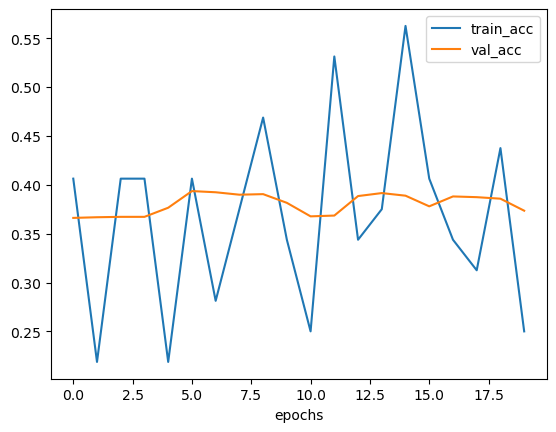

In [86]:
acc.plot.line();

### **GRU Model:**

In [87]:
metrics = pd.read_csv('./lightning_logs/GRU/version_0/metrics.csv')
val_acc = metrics['validation accuracy'].dropna().reset_index(drop=True).to_frame()
val_acc.index.name = 'epochs'
val_acc.columns = ['val_acc']
train_acc = metrics['training accuracy'].dropna().reset_index(drop=True).to_frame()
train_acc.index.name = 'epochs'
train_acc.columns = ['train_acc']
acc = train_acc.merge(val_acc, left_index=True, right_index=True)
acc

,train_acc,val_acc
epochs,,
0,0.43750,0.609949
1,0.40625,0.765330
2,0.46875,0.816373
3,0.31250,0.844283
4,0.56250,0.854208
5,0.50000,0.866658
6,0.37500,0.878653
7,0.53125,0.879410
8,0.56250,0.884474


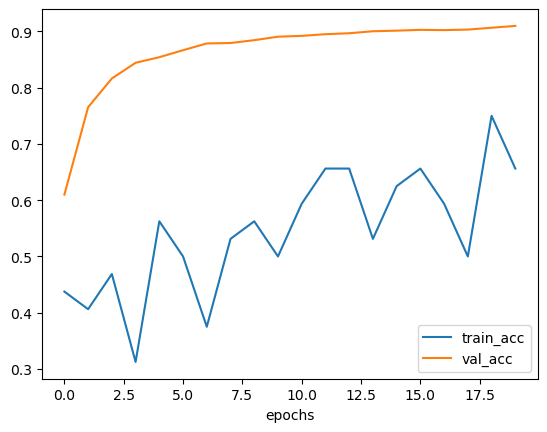

In [88]:
acc.plot.line();

### **LSTM Model:**

In [89]:
metrics = pd.read_csv('./lightning_logs/LSTM/version_0/metrics.csv')
val_acc = metrics['validation accuracy'].dropna().reset_index(drop=True).to_frame()
val_acc.index.name = 'epochs'
val_acc.columns = ['val_acc']
train_acc = metrics['training accuracy'].dropna().reset_index(drop=True).to_frame()
train_acc.index.name = 'epochs'
train_acc.columns = ['train_acc']
acc = train_acc.merge(val_acc, left_index=True, right_index=True)
acc

,train_acc,val_acc
epochs,,
0,0.40625,0.365909
1,0.18750,0.367171
2,0.37500,0.367188
3,0.50000,0.367171
4,0.31250,0.367154
5,0.40625,0.367171
6,0.34375,0.367154
7,0.37500,0.367188
8,0.34375,0.367188


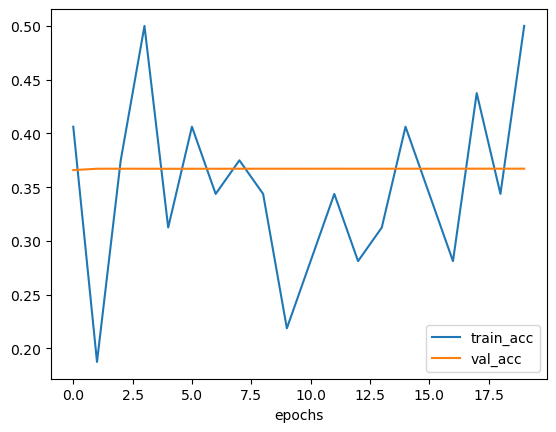

In [90]:
acc.plot.line();